# SPECTRA STUDIES

In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec

import csth.utils.photopeak_fit as pk

from scipy import optimize
from matplotlib.patches import Rectangle

In [2]:
# Plotting style
default_cmap = "viridis"
figure_size  = 15, 5
font_size    = 14

plt.rcParams["figure.figsize"]  = figure_size
plt.rcParams[  "font.size"   ]  = font_size
plt.rcParams[  "image.cmap"  ]  = default_cmap
plt.rcParams["axes.facecolor"]  = 'ghostwhite'
#plt.rcParams["axes.grid"     ]  = True
plt.rcParams["grid.color"    ]  = 'lightgrey'
plt.rcParams["axes.formatter.limits"] = -4, 4
plt.rcParams["font.family"]='serif'

#plt.style.use(plt.style.available[10])

#set number of bins
nbins = 100

In [3]:
def plottext(res, cov, n):
    mus, smus = int(round(res.x[0])), int(round(cov[0][0]**.5))
    mub, smub = int(round(res.x[1])), int(round(cov[1][1]**.5))
    s, ss     = res.x[2], cov[2][2]**.5
    mu, smu   = int(round(res.x[3])), int(round(cov[3][3]**.5))
    sig, ssig = int(round(res.x[4])), int(round(cov[4][4]**.5))

    tres = (fr'$\mu_s    = {mus}\pm{smus}$' + '\n' +
            fr'$\mu_b    = {mub}\pm{smub}$' + '\n' +
            fr'$E_{{ph}} = {mu} \pm {smu}$' + '\n' +
            fr'$\sigma   = {sig} \pm {ssig}$' + '\n'+
            fr'Total Entries: {n}')
    return tres


def fitplot(E, lims, res, cov, nbins):
    a, b =lims
    fig = plt.figure()
    ax = fig.add_subplot(111)

    h, _, _ = ax.hist(E, bins=int(nbins), alpha=0.5, histtype='step', color='darkblue', linewidth=2);
    e = np.linspace(a, b, 1000)
    ax.plot(e, ((b-a)/nbins*len(E))*pk.pkpdf(e, res.x, [a,b]), c='black')

    ax.text(a, h.max()/2., s=plottext(res, cov, len(E)))

    ax.set_xlabel('Energy (pes)');
    ax.set_ylabel('Entries');
    

def varsplot(data, var, nbins):
    fig_e = plt.figure(figsize =[17, 10], constrained_layout=True);
    gs_e = gridspec.GridSpec(round(len(var)/5+.4), 5, figure=fig_e);

    edf = data.dropna()

    i=0
    for v in var:
        axes    = f'ax_e{v}   = fig_e.add_subplot(gs_e[{i}])'
        exec(axes)
        hist       = (f'hist_e{v} = ax_e{v}.hist2d(edf["{v}"], edf["e"] ,bins=nbins,' + 
                  f'range=((np.mean(edf["{v}"])-1.5*np.std(edf["{v}"]), np.mean(edf["{v}"])+1.5*np.std(edf["{v}"])), (a, b)))')
        exec(hist)
        labels     = (f'ax_e{v}.set_xlabel("{v}", fontsize=15) \n'+
                      f'ax_e{v}.ticklabel_format(style="sci", axis="y", scilimits=(0,0))')
        exec(labels)
        i+=1
    # for v in var:
    #     cbars      = f'cbar_e{v} = fig_e.colorbar(hist_e{v}[3], ax = ax_e{v})'
    #     exec(cbars)
    #     fig_e.suptitle(f'E (pes) vs Variables', fontsize=16);
    
def F(E, p, c):
    return p*E + c

def chisq(F, popt, xdata, ydata, ydataerr):
    return np.sum((F(xdata, *popt)-ydata)**2/ydataerr**2)/(len(xdata)-len(popt))

In [4]:
runs = [6482, 6483, 6484, 6485]

directory = '../../DATA/'
filenames  = [f'cepks_{run}_0000_11999_6q0min.h5' for run in runs]

data = pd.concat([pd.HDFStore(directory + filename)['/esum'] for filename in filenames])

data['time']=data['time']*10**-10

In [5]:
#fiducialization
#data = data[(50<data.z)&(data.z<500)&(data.x**2+data.y**2+data.z**2<180**2)]
data.keys()

Index(['event', 'peak', 'location', 'nslices', 'nhits', 'noqslices', 'time',
       's1e', 't0', 'rmax', 'rsize', 'zmax', 'zsize', 'x0', 'y0', 'z0', 'e0',
       'q0', 'e0h', 'q0h', 'x', 'y', 'z', 'q', 'e', 'eh', 'qh', 'xu', 'yu',
       'zu', 'e0f', 'e0b', 'ef', 'eb', 'e1', 'x1', 'y1', 'z1', 'e2', 'x2',
       'y2', 'z2', 'eblob1', 'eblob2', 'd12'],
      dtype='object')

In [6]:
var = ['nslices', 'nhits', 'noqslices', 'time',
       's1e', 't0', 'rmax', 'rsize', 'zmax', 'zsize', 'x0', 'y0', 'z0', 'e0',
       'q0', 'x', 'y', 'z', 'q', 'e']

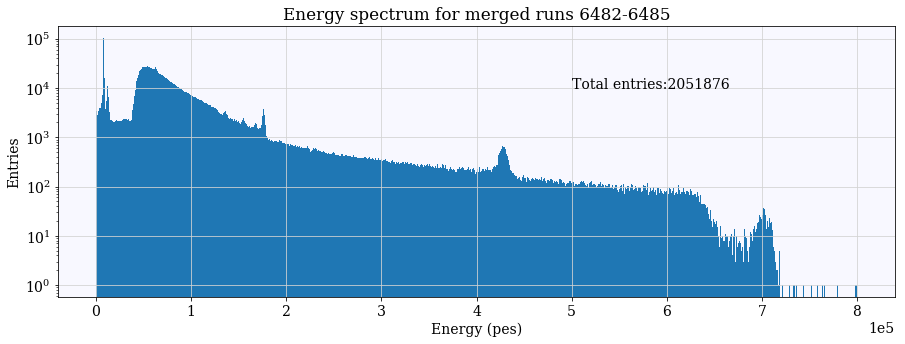

In [7]:
E = data[(data['e']<8e5)]['e']

fig = plt.figure(figsize=[15, 5])
ax = fig.add_subplot(111)
ax.set_title('Energy spectrum for merged runs 6482-6485')

ax.hist(E, bins=int(10*nbins), log=True);

ax.text(5e5, 1e4, s=f'Total entries:{len(E)}')

ax.grid();
ax.set_xlabel('Energy (pes)');
ax.set_ylabel('Entries');

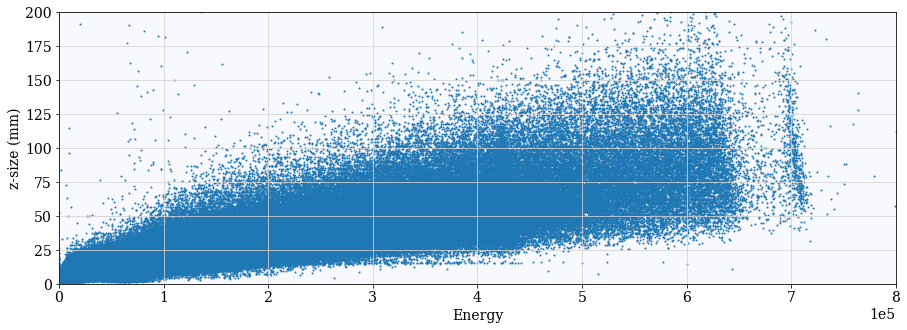

In [8]:
plt.scatter(data.e, data.zsize, s=1)

plt.xlim(0e5, 8e5);
plt.ylim(0, 2e2);

plt.grid();
plt.ylabel('z-size (mm)');
plt.xlabel('Energy');

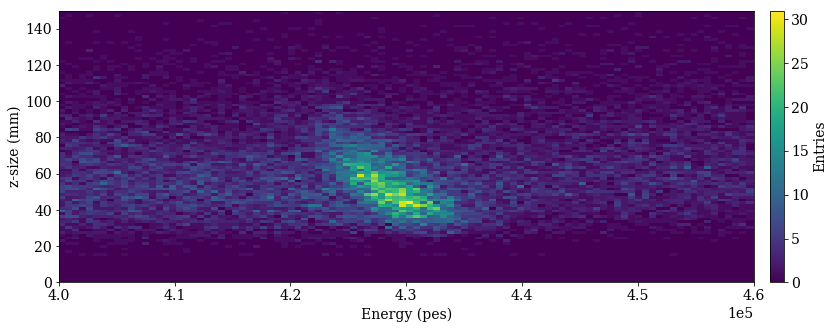

In [9]:
e1, e2 = 4e5, 4.6e5
z1, z2 = 0, 150

fig = plt.figure()
ax = fig.add_subplot(111)
ht=ax.hist2d(data.e, data.zsize, range=((e1, e2), (z1, z2)), bins=nbins);

cbar = fig.colorbar(ht[3], ax = ax, pad=0.02)
cbar.ax.set_ylabel('Entries')

ax.set_ylabel('z-size (mm)')
ax.set_xlabel('Energy (pes)');

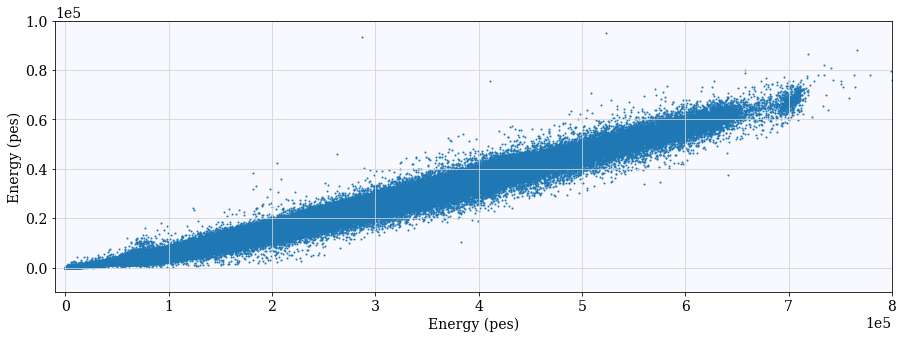

In [10]:
plt.scatter(data.e, data.q, s=1)

plt.xlim(-1e4, 8e5);
plt.ylim(-1e4, 1e5);
# plt.xlim(1e5, 8e5);
# plt.ylim(5, 2e1);

plt.grid();
plt.xlabel('Energy (pes)');
plt.ylabel('Energy (pes)');

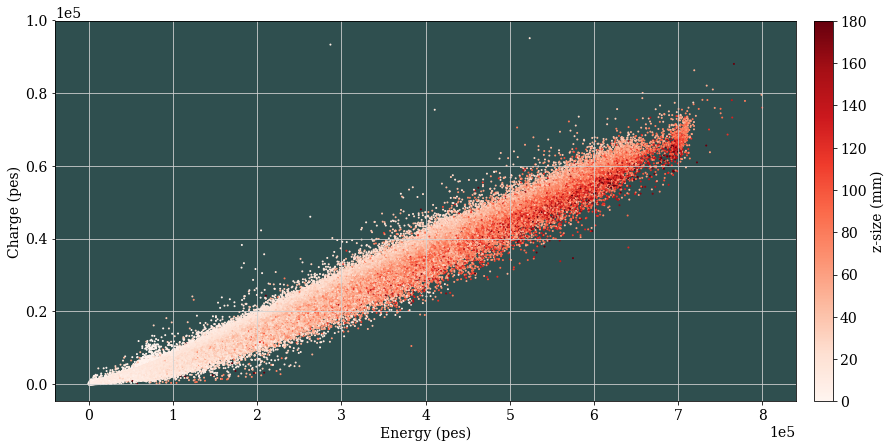

In [30]:
e1, e2 = 0e5, 8e5
q1, q2 = 0e4, 1e5

df = data[(e1<data.e)&(data.e<e2)&(q1<data.q)&(data.q<q2)]

#fiducial
#df = df[(50<df.z)&(df.z<500)&(df.x**2+df.y**2+df.z**2<180**2)]

cmin, cmax = 0e2, 1.8e2

fig = plt.figure(figsize=[16, 7])
ax = fig.add_subplot(111)
#ht = ax.hist2d(df.e, df.q, bins=nbins, weights=df.zsize, cmap='jet');
ht = ax.scatter(df.e, df.q, s=1, c=df.zsize, cmap='Reds', vmin=cmin, vmax=cmax)

cbar = fig.colorbar(ht, ax = ax, pad=0.02)
cbar.ax.set_ylabel('z-size (mm)')


ax.set_facecolor('darkslategray')

ax.grid();
ax.set_xlabel('Energy (pes)');
ax.set_ylabel('Charge (pes)');

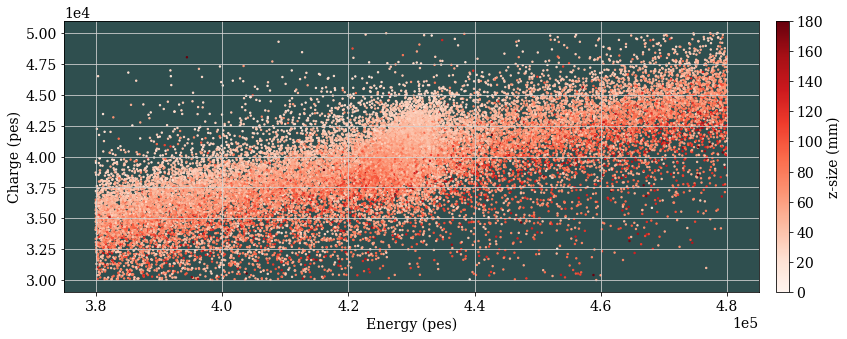

In [29]:
e1, e2 = 3.8e5, 4.8e5
q1, q2 = 3e4, 5e4

df = data[(e1<data.e)&(data.e<e2)&(q1<data.q)&(data.q<q2)]

#fiducial
#df = df[(50<df.z)&(df.z<500)&(df.x**2+df.y**2+df.z**2<180**2)]

cmin, cmax = 0e2, 1.8e2

fig = plt.figure()
ax = fig.add_subplot(111)
#ht = ax.hist2d(df.e, df.q, bins=nbins, weights=df.zsize, cmap='jet');
ht = ax.scatter(df.e, df.q, s=2, c=df.zsize, cmap='Reds', vmin=cmin, vmax=cmax)

cbar = fig.colorbar(ht, ax = ax, pad=0.02)
cbar.ax.set_ylabel('z-size (mm)')


#ax.set_xlim(e1,e2)
#ax.set_ylim(q1,q2)

ax.set_facecolor('darkslategray')

ax.grid();
ax.set_xlabel('Energy (pes)');
ax.set_ylabel('Charge (pes)');

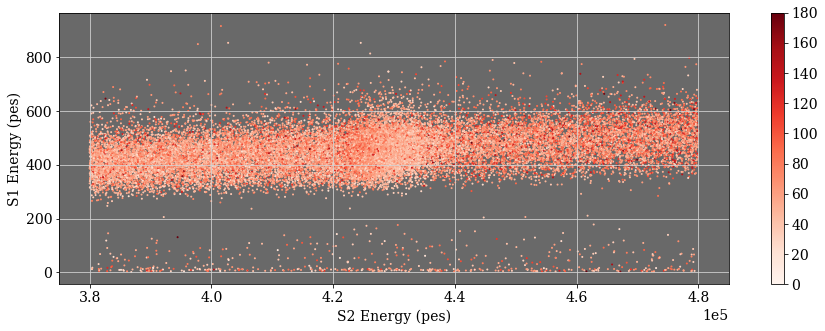

In [29]:
e1, e2  = 0, 8e5
s1e1, s1e2 = 0, 0.1e4

e1, e2 = 3.8e5, 4.8e5

df = data[(e1<data.e)&(data.e<e2)&(s1e1<data.s1e)&(data.s1e<s1e2)]

#fiducial
#df = df[(50<df.z)&(df.z<500)&(df.x**2+df.y**2+df.z**2<180**2)]

cmin, cmax = 0e2, 1.8e2

fig = plt.figure()
ax = fig.add_subplot(111)
#ht = ax.hist2d(df.e, df.q, bins=nbins, weights=df.zsize, cmap='jet');
ht = ax.scatter(df.e, df.s1e, s=1, c=df.zsize, cmap='Reds', vmin=cmin, vmax=cmax)

fig.colorbar(ht, ax = ax)


#ax.set_xlim(e1,e2)
#ax.set_ylim(q1,q2)

ax.set_facecolor('dimgray')

ax.grid();
ax.set_xlabel('S2 Energy (pes)');
ax.set_ylabel('S1 Energy (pes)');

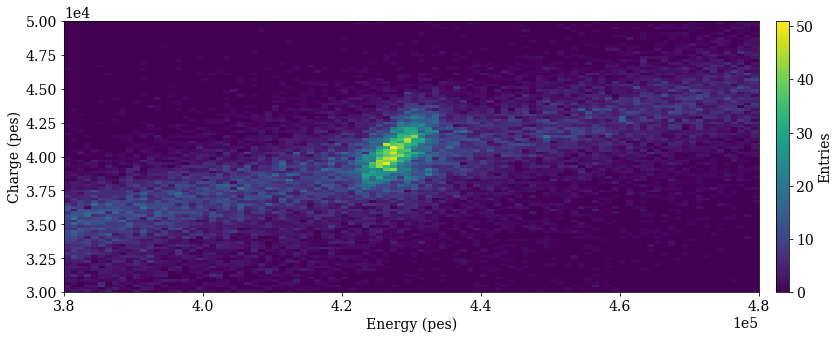

In [62]:
e1, e2 = 3.8e5, 4.8e5
q1, q2 = 3e4, 5e4

df = data[(e1<data.e)&(data.e<e2)&(q1<data.q)&(data.q<q2)]

fig = plt.figure()
ax = fig.add_subplot(111)

ht=ax.hist2d(df.e, df.q, range=((e1, e2), (q1, q2)), bins=nbins);
#ax.scatter(df.e, df.q, s=1);

cbar = fig.colorbar(ht[3], ax = ax, pad=0.02)
cbar.ax.set_ylabel('Entries')

ax.set_xlabel('Energy (pes)')
ax.set_ylabel('Charge (pes)');

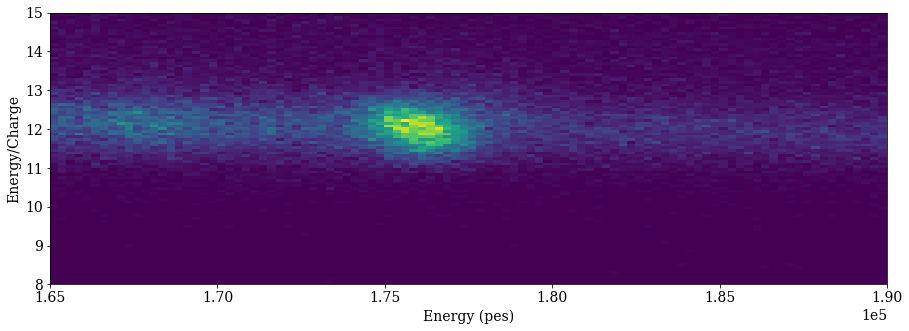

In [31]:
e1, e2 = 1.65e5, 1.9e5
q1, q2 = 2e4, 6e4

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist2d(data.e, data.e/data.q, range=((e1, e2), (8, 15)), bins=nbins);


ax.set_xlabel('Energy (pes)')
ax.set_ylabel('Energy/Charge');

# Th photopeak

In [32]:
a, b = 6.6e5, 7.3e5

thpk = data[(a<data['e'])&(data['e']<b)]

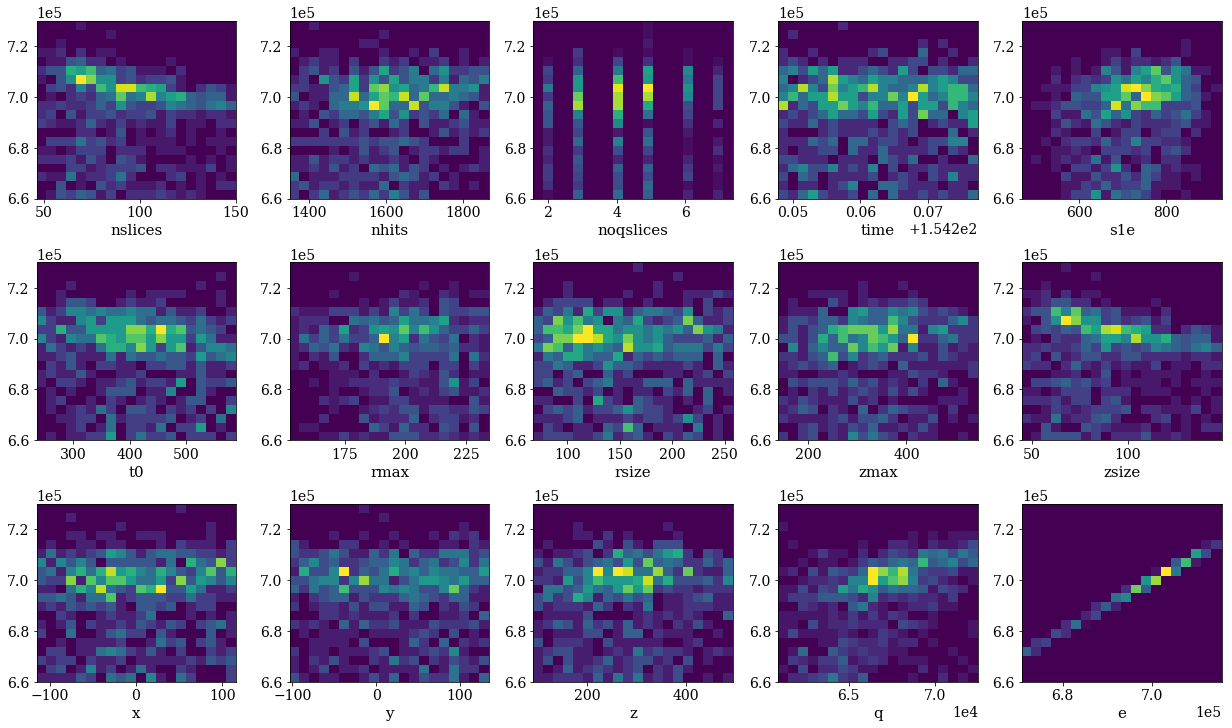

In [11]:
var = ['nslices', 'nhits', 'noqslices', 'time',
       's1e', 't0', 'rmax', 'rsize', 'zmax', 'zsize', 'x', 'y', 'z', 'q', 'e']
varsplot(thpk, var, .2*nbins)

Optimization terminated successfully.
         Current function value: 2402.910392
         Iterations: 17
         Function evaluations: 1938
Optimization terminated successfully.
         Current function value: 3374.152806
         Iterations: 12
         Function evaluations: 1520
Optimization terminated successfully.
         Current function value: 2594.093874
         Iterations: 11
         Function evaluations: 1281
Optimization terminated successfully.
         Current function value: 1493.886259
         Iterations: 13
         Function evaluations: 1487
Optimization terminated successfully.
         Current function value: 1017.374480
         Iterations: 32
         Function evaluations: 3563


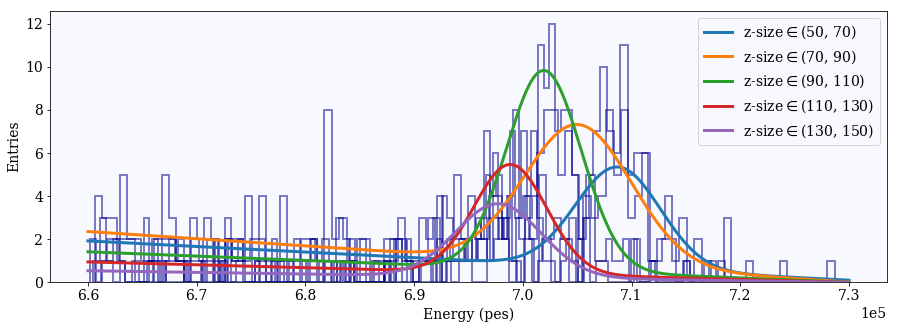

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)

a, b = 6.6e5, 7.3e5
df=thpk

mus, muserr = [], []
zsizes = np.linspace(50, 150, 6)
for i in range(0, len(zsizes)-1):
    #fit for each zsize
    l, u = zsizes[i], zsizes[i+1]
    prof = df[(l<df.zsize)&(df.zsize<u)]
    E = prof['e']
    x0 = np.array([.5*len(E), .5*len(E), 0, np.mean(E), np.std(E)])
    res, cov = pk.pkfit(E, [a,b], x0=x0)
    mus.append(res.x[3])
    muserr.append(cov[3,3]**0.5)
    
    #plot
    ax.hist(E.values, bins=int(nbins), alpha=0.5, histtype='step', color='darkblue', linewidth=2);
    e = np.linspace(a, b, 1000)
    ax.plot(e, ((b-a)/nbins*len(E))*pk.pkpdf(e, res.x, [a,b]), label=fr'z-size$\in$({int(l)}, {int(u)})', linewidth=3)

#ax.text(a, h.max()/2., s=plottext(res, cov, len(E)))

mus, muserr = np.array(mus), np.array(muserr)
ax.legend()
ax.set_xlabel('Energy (pes)');
ax.set_ylabel('Entries');

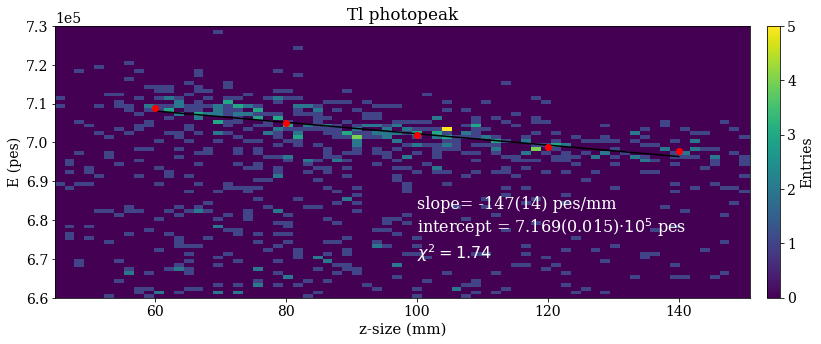

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Tl photopeak')

#2dhistogram
zmin, zmax = np.mean(df['zsize'])-1.5*np.std(df['zsize']), np.mean(df['nslices'])+1.5*np.std(df['nslices'])
ht = ax.hist2d(df['zsize'], df["e"] , bins=.7*nbins, range=((zmin, zmax), (a, b)))

#profile
zs = np.array([(zsizes[i+1]+zsizes[i])/2. for i in range(0, len(zsizes)-1)])
ax.errorbar(zs, mus, yerr=muserr, fmt='o', c='r')

#fitting
popt, pcov = optimize.curve_fit(F, zs, mus, p0 =[0, 0], sigma = muserr)
p, c = popt[0], popt[1]
perr, cerr = pcov[0,0]**0.5, pcov[1,1]**0.5
e=np.linspace(zs.min(), zs.max())
ax.plot(e, p*e + c, c='black');

#fit result
tx = (fr'slope= {int(round(p))}({int(round(perr))}) pes/mm  '+'\n'+
      fr'intercept = {round(c*10**-5, 3)}({round(cerr*10**-5, 3)})$\cdot 10^{{5}}$ pes'+'\n'+
      fr'$\chi^2= {round(chisq(F, popt, zs, mus, muserr), 2)}$')

ax.text(100, 6.7e5, s=tx, color='white', fontsize=16)


cbar = fig.colorbar(ht[3], ax = ax, pad=0.02)
cbar.ax.set_ylabel('Entries')


ax.set_xlabel('z-size (mm)', fontsize=15)
ax.set_ylabel('E (pes)')
ax.ticklabel_format(style="sci", axis="y", scilimits=(0,0))

# Th double escape

In [42]:
a, b = 4.1e5, 4.45e5

thds = data[(a<data['e'])&(data['e']<b)]

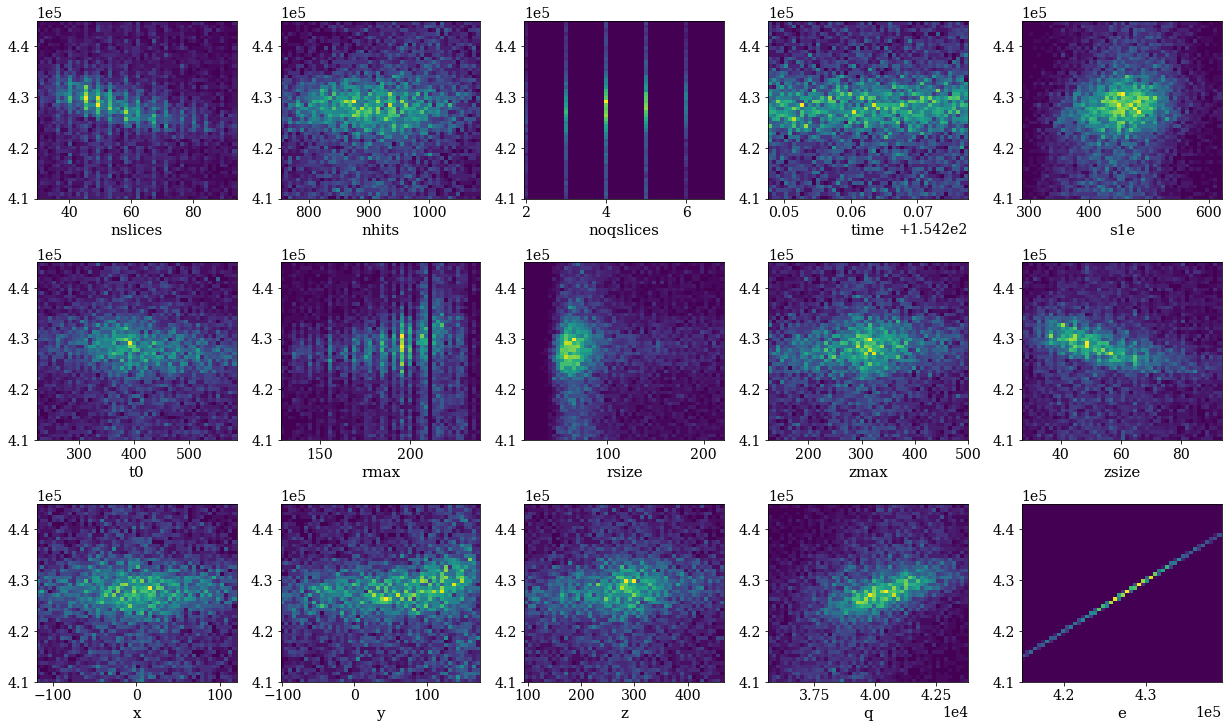

In [15]:
var = ['nslices', 'nhits', 'noqslices', 'time',
       's1e', 't0', 'rmax', 'rsize', 'zmax', 'zsize', 'x', 'y', 'z', 'q', 'e']
varsplot(thds, var, .5*nbins)

Optimization terminated successfully.
         Current function value: 5524.431871
         Iterations: 15
         Function evaluations: 1576
Optimization terminated successfully.
         Current function value: 6672.733593
         Iterations: 17
         Function evaluations: 1737
Optimization terminated successfully.
         Current function value: 7524.939121
         Iterations: 13
         Function evaluations: 1073
Optimization terminated successfully.
         Current function value: 8984.399121
         Iterations: 18
         Function evaluations: 2079
Optimization terminated successfully.
         Current function value: 9182.528083
         Iterations: 11
         Function evaluations: 1164
Optimization terminated successfully.
         Current function value: 9212.531073
         Iterations: 13
         Function evaluations: 1631
Optimization terminated successfully.
         Current function value: 9166.955553
         Iterations: 14
         Function evaluations: 1314

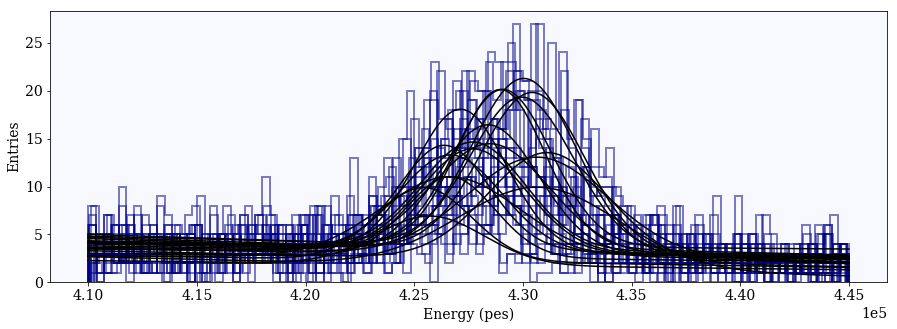

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)

a, b = 4.1e5, 4.45e5
df=thds

mus, muserr = [], []
zsizes = np.linspace(35, 75, 20)
for i in range(0, len(zsizes)-1):
    #fit for each zsize
    l, u = zsizes[i], zsizes[i+1]
    prof = df[(l<df.zsize)&(df.zsize<u)]
    E = prof['e']
    x0 = np.array([.5*len(E), .5*len(E), 0, np.mean(E), np.std(E)])
    res, cov = pk.pkfit(E, [a,b], x0=x0)
    mus.append(res.x[3])
    muserr.append(cov[3,3]**0.5)
    
    #plot
    ax.hist(E, bins=int(nbins), alpha=0.5, histtype='step', color='darkblue', linewidth=2);
    e = np.linspace(a, b, 1000)
    ax.plot(e, ((b-a)/nbins*len(E))*pk.pkpdf(e, res.x, [a,b]), c='black')

#ax.text(a, h.max()/2., s=plottext(res, cov, len(E)))

mus, muserr = np.array(mus), np.array(muserr)

ax.set_xlabel('Energy (pes)');
ax.set_ylabel('Entries');

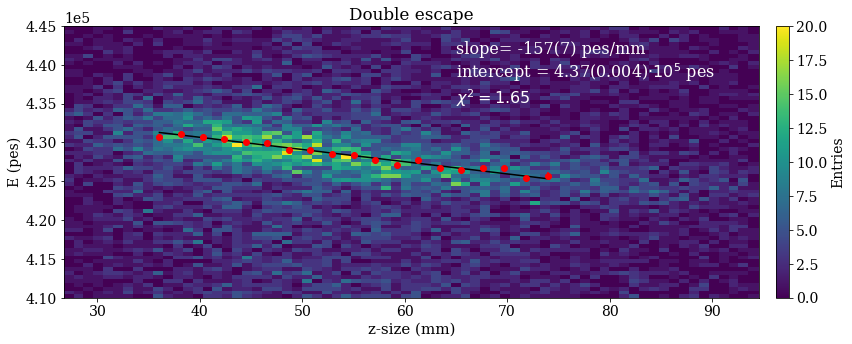

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Double escape')

#2dhistogram
zmin, zmax = np.mean(df['zsize'])-1.5*np.std(df['zsize']), np.mean(df['nslices'])+1.5*np.std(df['nslices'])
ht=ax.hist2d(df['zsize'], df["e"] , bins=.7*nbins, range=((zmin, zmax), (a, b)))

#profile
zs = np.array([(zsizes[i+1]+zsizes[i])/2. for i in range(0, len(zsizes)-1)])
ax.errorbar(zs, mus, yerr=muserr, fmt='o', c='r')

#fitting
popt, pcov = optimize.curve_fit(F, zs, mus, p0 =[0, 0], sigma = muserr)
p, c = popt[0], popt[1]
perr, cerr = pcov[0,0]**0.5, pcov[1,1]**0.5
e=np.linspace(zs.min(), zs.max())
ax.plot(e, p*e + c, c='black');

#fit result
tx = (fr'slope= {int(round(p))}({int(round(perr))}) pes/mm  '+'\n'+
      fr'intercept = {round(c*10**-5, 3)}({round(cerr*10**-5, 3)})$\cdot 10^{{5}}$ pes'+'\n'+
      fr'$\chi^2= {round(chisq(F, popt, zs, mus, muserr), 2)}$')

ax.text(65, 4.35e5, s=tx, color='white', fontsize=16)

cbar = fig.colorbar(ht[3], ax = ax, pad=0.02)
cbar.ax.set_ylabel('Entries')

ax.set_xlabel('z-size (mm)', fontsize=15)
ax.set_ylabel('E (pes)')
ax.ticklabel_format(style="sci", axis="y", scilimits=(0,0))

# Cs photopeak

In [46]:
a, b = 1.65e5, 1.9e5

cspk = data[(a<data['e'])&(data['e']<b)]

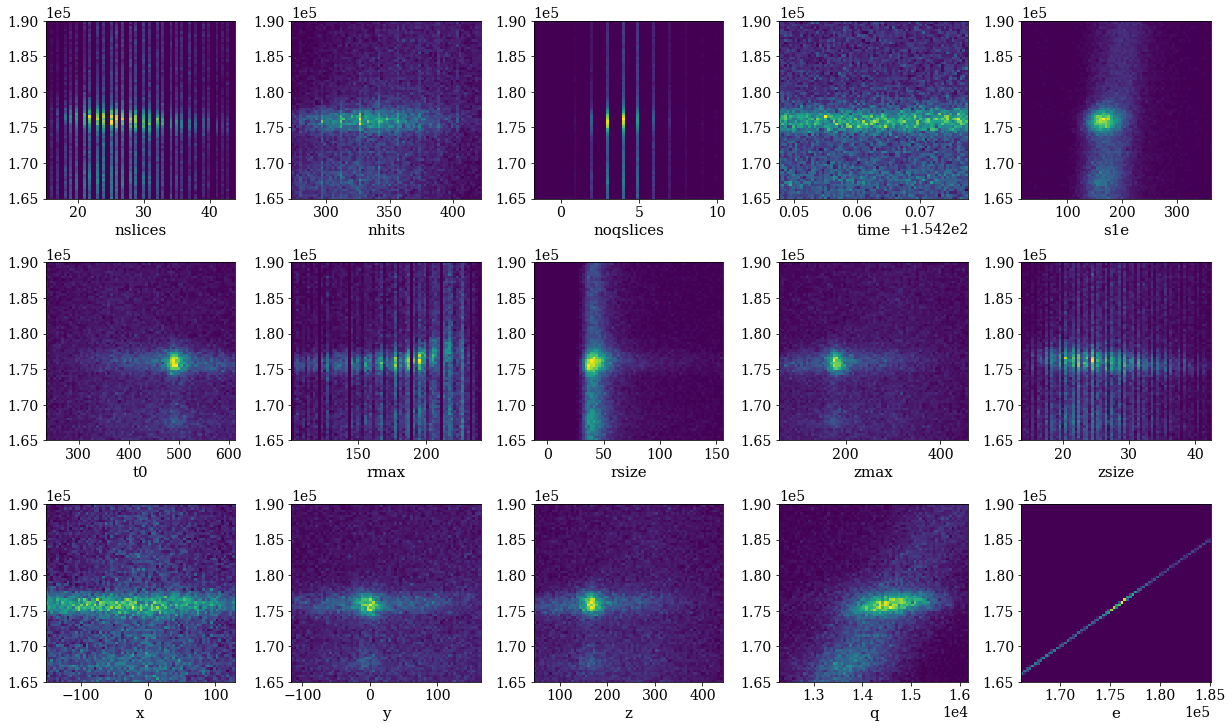

In [19]:
var = ['nslices', 'nhits', 'noqslices', 'time',
       's1e', 't0', 'rmax', 'rsize', 'zmax', 'zsize', 'x', 'y', 'z', 'q', 'e']
varsplot(cspk, var, .7*nbins)

Optimization terminated successfully.
         Current function value: 44249.876407
         Iterations: 16
         Function evaluations: 1796
Optimization terminated successfully.
         Current function value: 77175.756283
         Iterations: 19
         Function evaluations: 1562
Optimization terminated successfully.
         Current function value: 94469.014802
         Iterations: 15
         Function evaluations: 1609
Optimization terminated successfully.
         Current function value: 105502.926240
         Iterations: 20
         Function evaluations: 2133
Optimization terminated successfully.
         Current function value: 100579.511011
         Iterations: 18
         Function evaluations: 1957
Optimization terminated successfully.
         Current function value: 77770.635455
         Iterations: 16
         Function evaluations: 1816
Optimization terminated successfully.
         Current function value: 54438.648153
         Iterations: 20
         Function evaluati

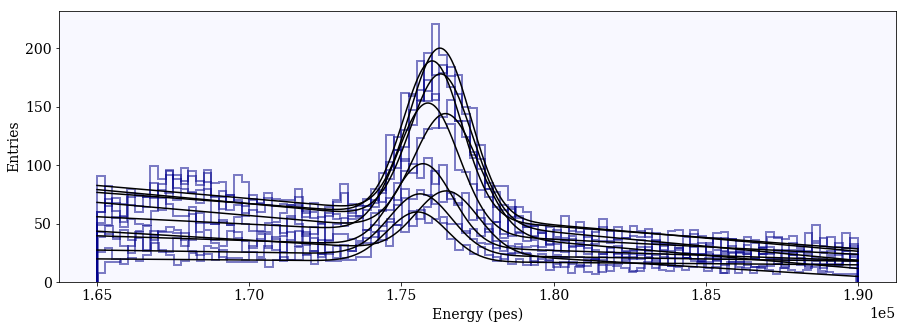

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111)

df=cspk

mus, muserr = [], []
zsizes = np.linspace(15, 40, 10)
for i in range(0, len(zsizes)-1):
    #fit for each zsize
    l, u = zsizes[i], zsizes[i+1]
    prof = df[(l<df.zsize)&(df.zsize<u)]
    E = prof['e']
    x0 = np.array([.5*len(E), .5*len(E), 0, np.mean(E), np.std(E)])
    res, cov = pk.pkfit(E, [a,b], x0=x0)
    mus.append(res.x[3])
    muserr.append(cov[3,3]**0.5)
    
    #plot
    ax.hist(E, bins=int(nbins), alpha=0.5, histtype='step', color='darkblue', linewidth=2);
    e = np.linspace(a, b, 1000)
    ax.plot(e, ((b-a)/nbins*len(E))*pk.pkpdf(e, res.x, [a,b]), c='black')

#ax.text(a, h.max()/2., s=plottext(res, cov, len(E)))

mus, muserr = np.array(mus), np.array(muserr)

ax.set_xlabel('Energy (pes)');
ax.set_ylabel('Entries');

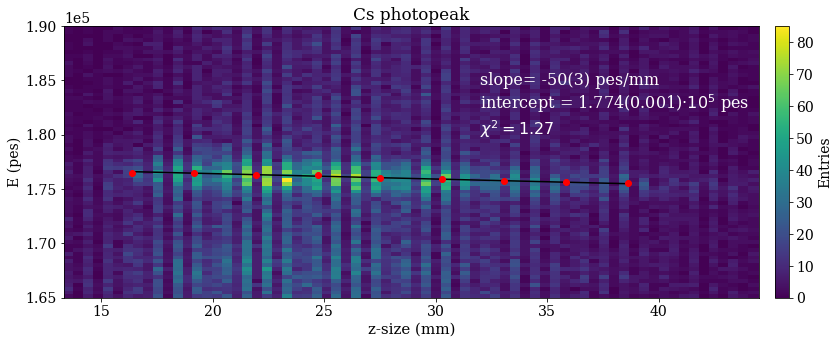

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Cs photopeak')

#2dhistogram
zmin, zmax = np.mean(df['zsize'])-1.5*np.std(df['zsize']), np.mean(df['nslices'])+1.5*np.std(df['nslices'])
ht=ax.hist2d(df['zsize'], df["e"] , bins=.7*nbins, range=((zmin, zmax), (a, b)))

#profile
zs = np.array([(zsizes[i+1]+zsizes[i])/2. for i in range(0, len(zsizes)-1)])
ax.errorbar(zs, mus, yerr=muserr, fmt='o', c='r')

#fitting
popt, pcov = optimize.curve_fit(F, zs, mus, p0 =[0, 0], sigma = muserr)
p, c = popt[0], popt[1]
perr, cerr = pcov[0,0]**0.5, pcov[1,1]**0.5
e=np.linspace(zs.min(), zs.max())
ax.plot(e, p*e + c, c='black');

#fit result
tx = (fr'slope= {int(round(p))}({int(round(perr))}) pes/mm  '+'\n'+
      fr'intercept = {round(c*10**-5, 3)}({round(cerr*10**-5, 3)})$\cdot 10^{{5}}$ pes'+'\n'+
      fr'$\chi^2= {round(chisq(F, popt, zs, mus, muserr), 2)}$')

ax.text(32, 1.8e5, s=tx, color='white', fontsize=16)

cbar = fig.colorbar(ht[3], ax = ax, pad=0.02)
cbar.ax.set_ylabel('Entries')

ax.set_xlabel('z-size (mm)', fontsize=15)
ax.set_ylabel('E (pes)')
ax.ticklabel_format(style="sci", axis="y", scilimits=(0,0))

# Tl peaks

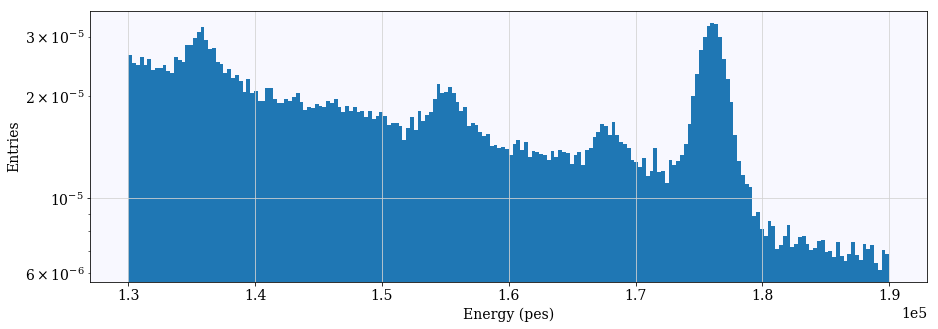

In [19]:
a, b = 1.3e5, 1.9e5

preg = data[(a<data['e'])&(data['e']<b)]
E = preg['e']

fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(E, bins=int(2*nbins), log=True, density=True);

ax.grid();
ax.set_xlabel('Energy (pes)');
ax.set_ylabel('Entries');

## Peak 1

In [20]:
a, b = 1.5e5, 1.6e5

pe1 = data[(a<data['e'])&(data['e']<b)]
E = pe1['e']

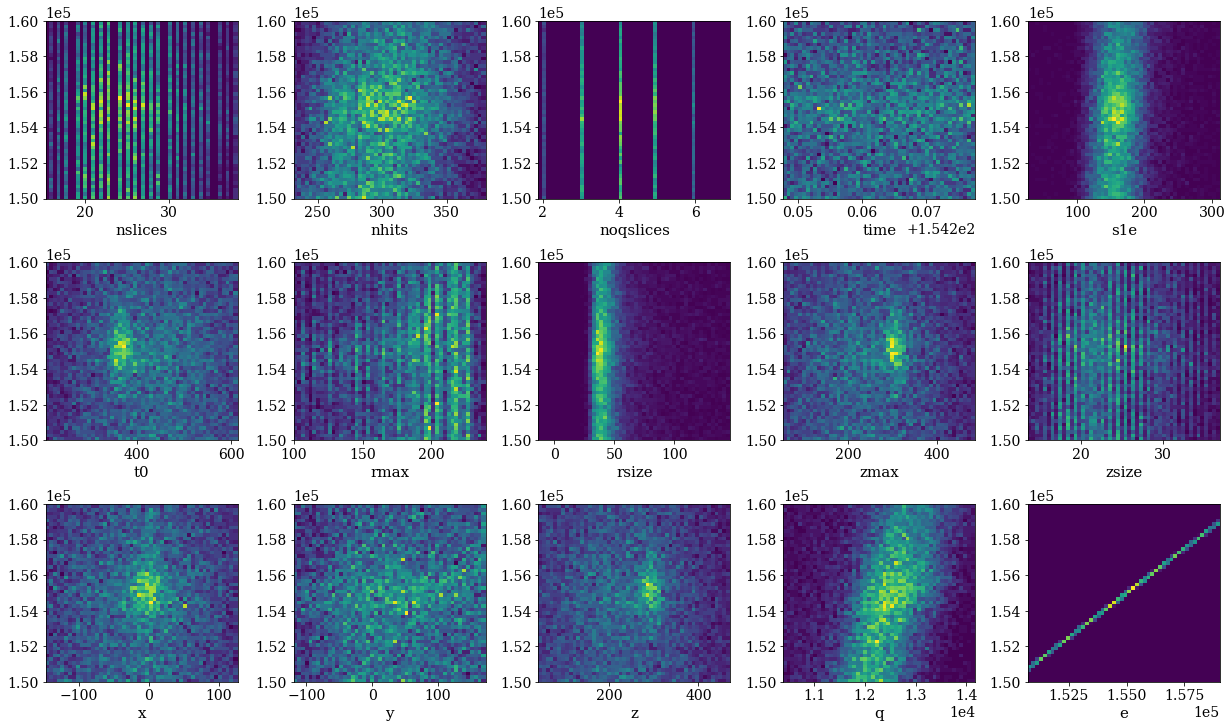

In [21]:
var = ['nslices', 'nhits', 'noqslices', 'time',
       's1e', 't0', 'rmax', 'rsize', 'zmax', 'zsize', 'x', 'y', 'z', 'q', 'e']
varsplot(pe1, var, .5*nbins)

## Peak 2

In [22]:
a, b = 1.3e5, 1.4e5

pe2 = data[(a<data['e'])&(data['e']<b)]
E = pe2['e']

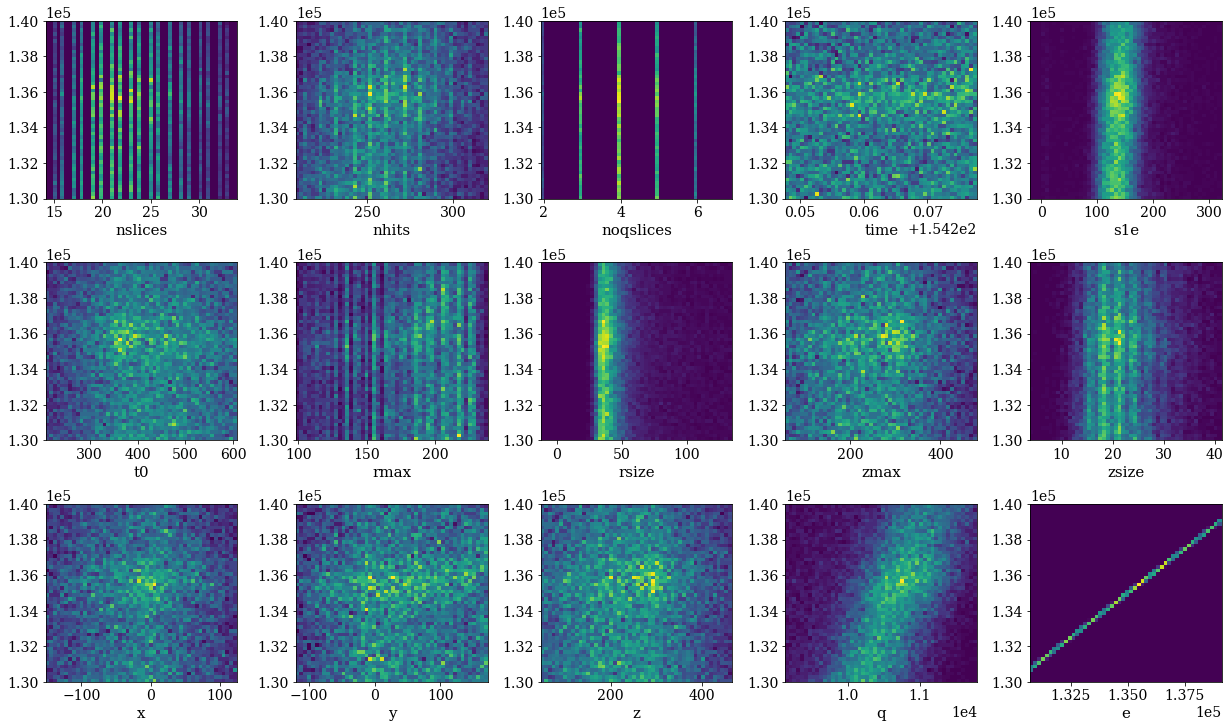

In [23]:
var = ['nslices', 'nhits', 'noqslices', 'time',
       's1e', 't0', 'rmax', 'rsize', 'zmax', 'zsize', 'x', 'y', 'z', 'q', 'e']
varsplot(pe2, var, .5*nbins)

# 212Pb

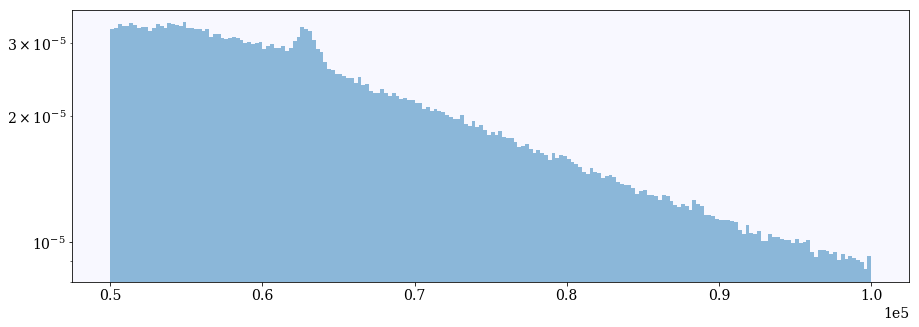

In [24]:
a, b = 0.5e5, 1e5

xray = data[(a<data['e'])&(data['e']<b)]
E = xray['e']

fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(E, bins=int(2*nbins), log=True, alpha=0.5, density=True);

In [25]:
a, b = .58e5, .68e5

unk = data[(a<data['e'])&(data['e']<b)]
E = unk['e']

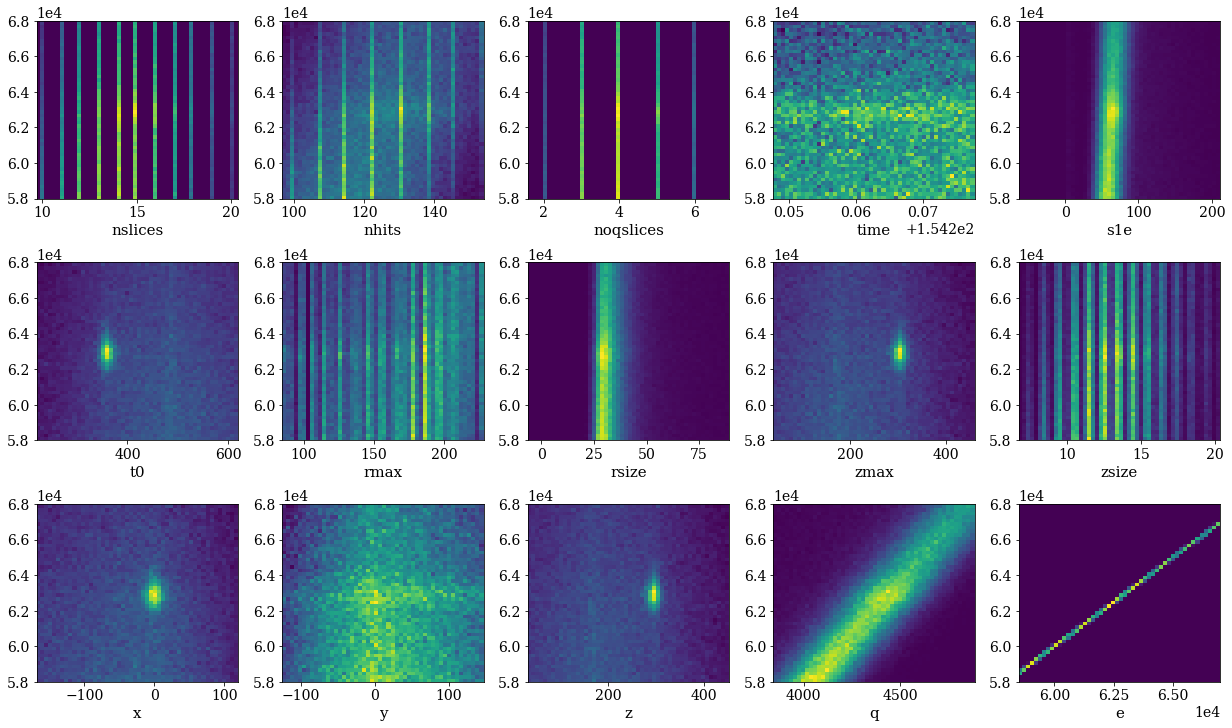

In [26]:
var = ['nslices', 'nhits', 'noqslices', 'time',
       's1e', 't0', 'rmax', 'rsize', 'zmax', 'zsize', 'x', 'y', 'z', 'q', 'e']
varsplot(unk, var, .5*nbins)

# Kr

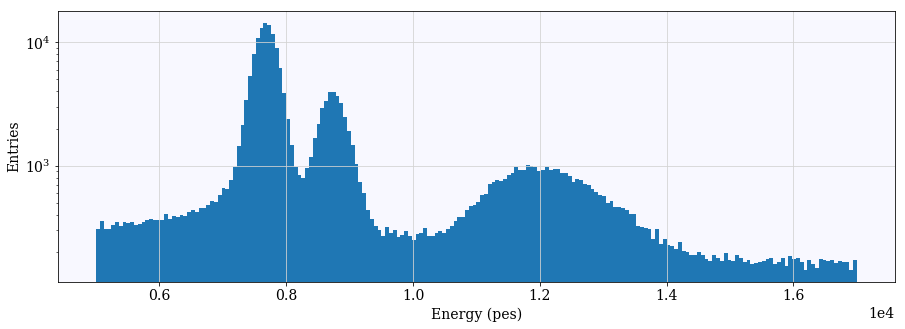

In [27]:
a, b = 0.05e5, 0.17e5

xray = data[(a<data['e'])&(data['e']<b)]
E = xray['e']

fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(E, bins=int(2*nbins), log=True);

ax.grid();
ax.set_xlabel('Energy (pes)');
ax.set_ylabel('Entries');

In [28]:
a, b = .1e5, .16e5

kr = data[(a<data['e'])&(data['e']<b)]
E = kr['e']

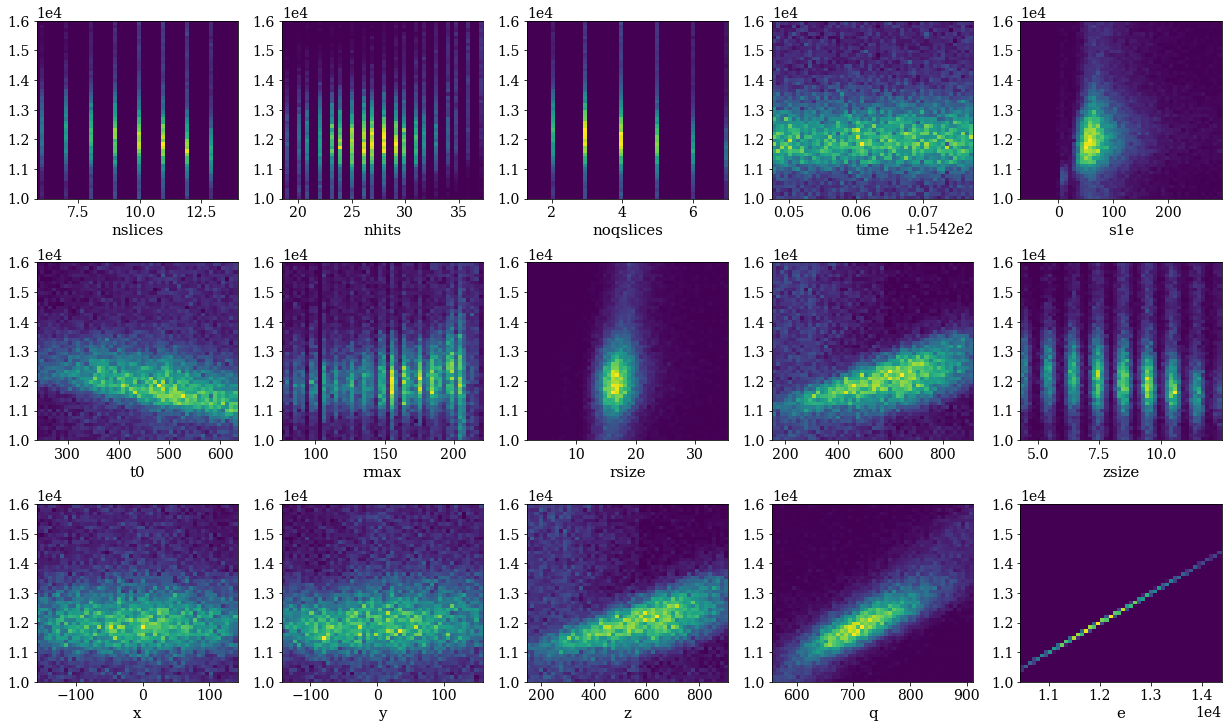

In [29]:
var = ['nslices', 'nhits', 'noqslices', 'time',
       's1e', 't0', 'rmax', 'rsize', 'zmax', 'zsize', 'x', 'y', 'z', 'q', 'e']
varsplot(kr, var, .5*nbins)

# XRays

## XRay 1

In [30]:
a, b = .083e5, .1e5

xr1 = data[(a<data['e'])&(data['e']<b)]
E = xr1['e']

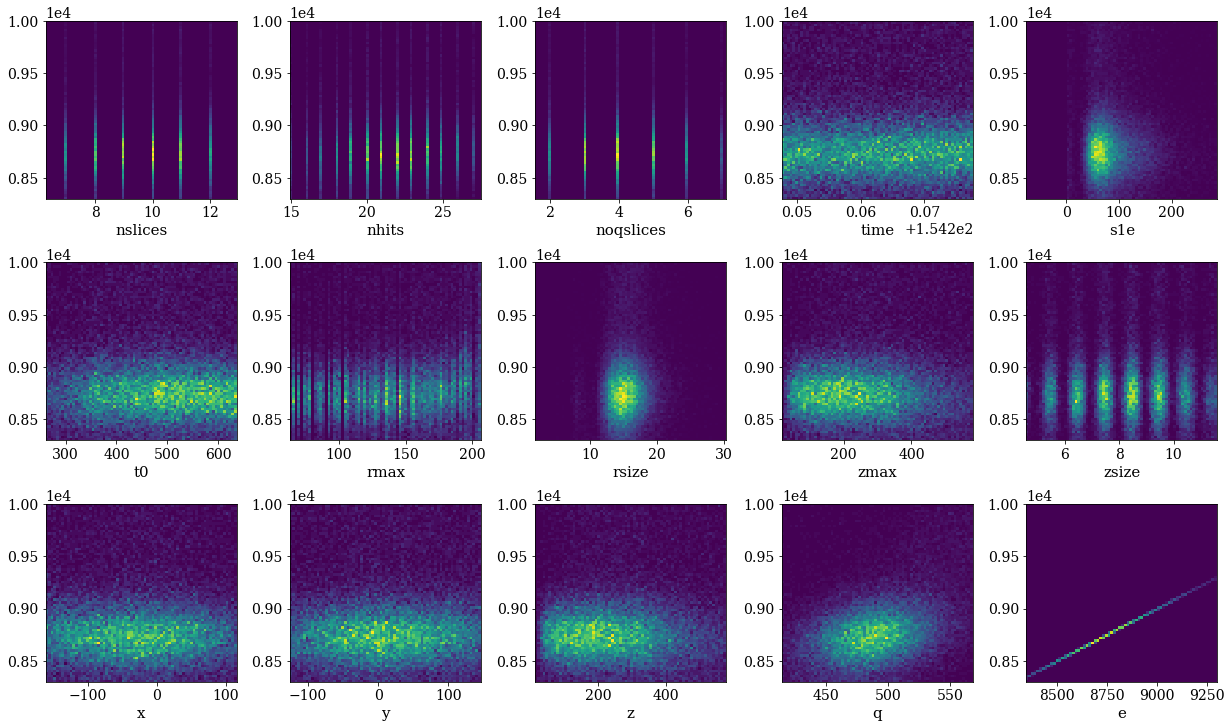

In [31]:
var = ['nslices', 'nhits', 'noqslices', 'time',
       's1e', 't0', 'rmax', 'rsize', 'zmax', 'zsize', 'x', 'y', 'z', 'q', 'e']
varsplot(xr1, var, .7*nbins)

## XRay 2

In [32]:
a, b = .065e5, .083e5

xr2 = data[(a<data['e'])&(data['e']<b)]
E = xr2['e']

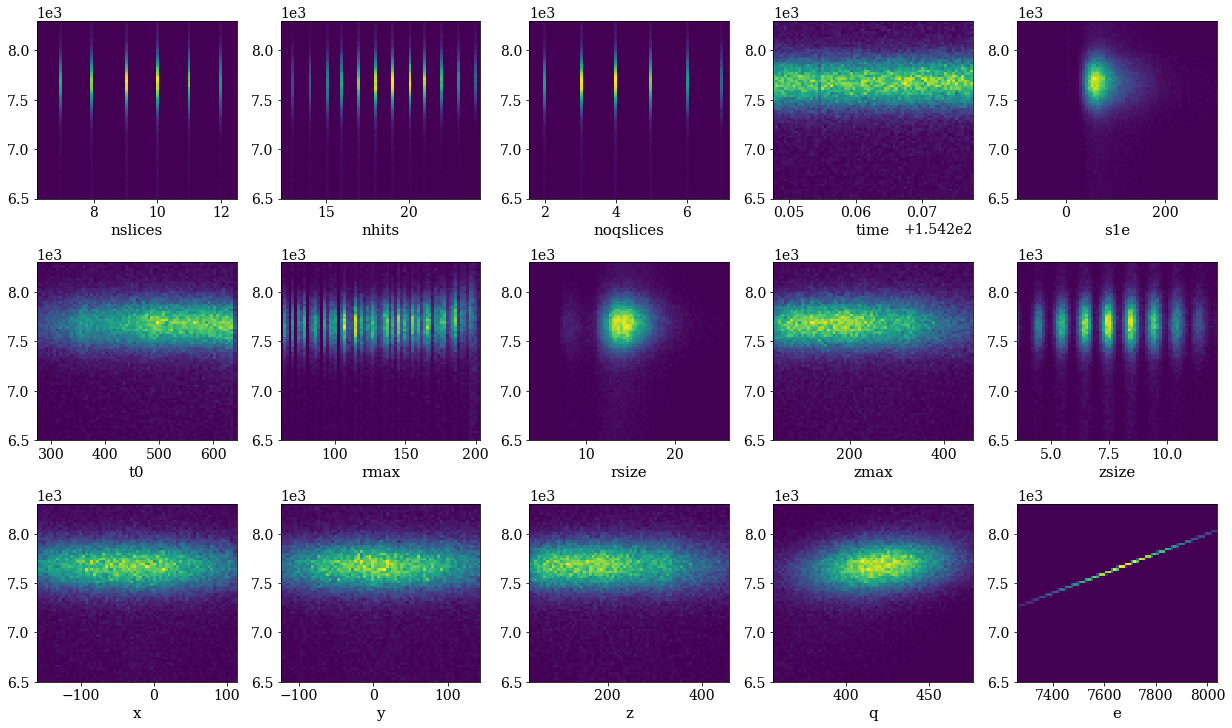

In [33]:
var = ['nslices', 'nhits', 'noqslices', 'time',
       's1e', 't0', 'rmax', 'rsize', 'zmax', 'zsize', 'x', 'y', 'z', 'q', 'e']
varsplot(xr2, var, .7*nbins)